In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax

In [2]:
def generate_two_spirals(n_points, noise=.5):
    """
    Returns the two spirals dataset.
    n_points: int, number of points in each spiral
    noise: float, noise added to the spiral points. Default is .5.
    """
    # 'n' is short for 'radius'. It determines the spread of the spiral.
    n = np.sqrt(np.random.rand(n_points, 1)) * 780 * (2 * np.pi) / 360

    # 'd1x' and 'd1y' represent the 'x' and 'y' coordinates of points in the first spiral
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise

    # Returning points from both spirals along with their respective labels
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))),
            np.hstack((np.zeros(n_points),np.ones(n_points))))


def log_sigmoid(z):
    """
    Computes logistic sigmoid function.
    z: float, input value
    """
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.max(0, z)


def make_network(layer_counts: list[int], std_distributions: list[float], activations: list[str]):
    """
    Returns arrays of weights and biases in order.
    :param layer_counts: a list of ints with length greater than 1, specifying the sizes of each layer in the network (including input layer)
    :param std_distributions: a list of float values, specifying the standard deviations for weight initialization of each layer
    :param activations:
    :return:
    """
    # 'w_arr' and 'b_arr' are lists to hold the weights and biases for each layer in the network
    w_arr = [np.random.normal(loc=0.0, scale=std_distributions[0], size=(layer_counts[1], layer_counts[0]))]
    b_arr = [np.zeros((layer_counts[1], 1))]

    act_functions = []
    for activation in activations:
        if activation == "relu":
            act_functions.append(relu)
        elif activation == "softmax":
            act_functions.append(softmax)
        else:
            act_functions.append(log_sigmoid)


    for layer_num in range(2, len(layer_counts)):
        # 'current_layer_count' refers to the size of the current layer
        current_layer_count = layer_counts[layer_num]

        # initialize weights and biases of 'layer_num'th hidden layer
        # 'w_i' and 'b_i' are the weights and biases for the current layer
        w_i = np.random.normal(loc=0.0, scale=std_distributions[layer_num - 1], size=(current_layer_count, layer_counts[layer_num - 1]))
        b_i = np.zeros((current_layer_count, 1))
        w_arr.append(w_i)
        b_arr.append(b_i)

    return w_arr, b_arr, act_functions


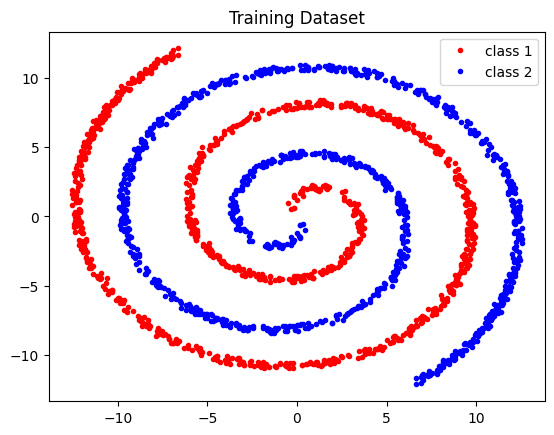

In [3]:
# Generate two spirals dataset with 1000 points in each spiral
features, labels = generate_two_spirals(1000)

# Nx: Total number of samples
# Dx: Number of dimensions or features
num_samples = features.shape[0]
num_features = features.shape[1]

# Convert label vector labels into np array
target = np.zeros((num_samples,1))
for i in np.arange(num_samples):
  target[i] = labels[i]

# Transpose of target vector
target_transpose = np.transpose(target)

# Plotting the generated data
plt.title('Training Dataset')

# Points from class 1 are plotted in red
plt.plot(features[labels==0,0], features[labels==0,1], '.', label='class 1',c='red')

# Points from class 2 are plotted in blue
plt.plot(features[labels==1,0], features[labels==1,1], '.', label='class 2',c='blue')

plt.legend()
plt.show()


In [4]:
# Setting parameters for Stochastic Gradient Descent (SGD) with Backpropagation Training of Multi-Layer Perceptron (MLP):

minibatch_size = 64  # Mini-batch size for SGD
learning_rate = 0.005  # Learning rate for SGD
max_epochs = 3000  # Maximum number of epochs before stopping training

# Array to keep track of the objective function value at each epoch
objective_func_values = np.zeros(max_epochs + 1)

# Create a neural network with 2 inputs, three hidden layers with 40, 30 and 30 neurons respectively, and 1 output
# Initialize weights with a standard deviation of 5.0 for each layer
weights, biases, act_functions = make_network(
    [2, 50, 50, 60, 75, 1],
    [2.5, 5.0, 5.0, 5.0, 7.5],
    ["rel", "elu", "elu", "elu", "oftmax"]
)


In [5]:
# Initialize arrays for storing activations and backpropagation deltas
activation_values = [None] * (len(weights) + 1)
backprop_deltas = [None] * len(weights)

# Begin epochs
for current_epoch in range(1, max_epochs + 1):
    objective_func_current_epoch = 0
    random_indices = np.random.permutation(num_samples)

    # Initial mini-batch index bounds
    lower_bound = 0
    upper_bound = minibatch_size
    for mini_batch_count in range(len(features) // minibatch_size):

        # Step 1: Forward Propagations - Calculate activations with logistic sigmoid.
        activation_values[0] = np.transpose(features[random_indices[lower_bound:upper_bound], :])
        for i in range(len(activation_values) - 1):
            activation_values[i + 1] = act_functions[i](weights[i] @ activation_values[i] + biases[i])

        # Step 2: Calculate error and begin backpropagation
        target_transpose_minibatch = target_transpose[None, 0, random_indices[lower_bound:upper_bound]]
        backprop_deltas[-1] = (activation_values[-1] - target_transpose_minibatch) * (activation_values[-1] * (1 - activation_values[-1]))
        for i in reversed(range(len(weights) - 1)):
            backprop_deltas[i] = (np.transpose(weights[i + 1]) @ backprop_deltas[i + 1]) * (activation_values[i + 1] * (1 - activation_values[i + 1]))

        # Step 3: Recalculate weights by subtracting gradients
        for i in range(len(weights)):
            biases[i] -= learning_rate * np.sum(backprop_deltas[i], axis=1, keepdims=True)
            weights[i] -= learning_rate * np.transpose(activation_values[i] @ np.transpose(backprop_deltas[i]))

        # Step 4: Update objective function
        objective_func_minibatch = np.sum(0.5 * (target_transpose_minibatch - activation_values[-1]) ** 2)   # compute objective function for current mini-batch
        objective_func_current_epoch += objective_func_minibatch

        # Update mini-batch bounds
        lower_bound += minibatch_size
        upper_bound += minibatch_size

    # Compute the objective function for the current epoch
    objective_func_current_epoch /= num_samples
    objective_func_values[current_epoch] = objective_func_current_epoch


KeyboardInterrupt: 

In [ ]:
# Print summary statistics of Stochastic Gradient Descent (SGD) with Backpropagation learning process:
print(f"SGD required {max_epochs} epochs to converge")
print(f"SGD Final Objective Function Value {objective_func_values[max_epochs]}")

# Define a grid of points (meshgrid) in the 2D feature space:
# np.meshgrid creates a rectangular grid out of two given 1D arrays representing the Cartesian coordinates in the x and y dimensions.
# This grid is used to feed these coordinates into the trained model and generate a prediction for the entire space spanned by the grid.
x_values = np.arange(-15, 15.1, 0.1)
y_values = np.arange(-15, 15.1, 0.1)
mesh_x, mesh_y = np.meshgrid(x_values, y_values, sparse=False, indexing='ij')
meshgrid_array = np.array([np.transpose(mesh_x.flatten()), np.transpose(mesh_y.flatten())])

# FEED INPUTS FORWARD through TRAINED neural network:
# Each point in the meshgrid is passed into the network and the output is stored
activation_input = meshgrid_array
for i in range(len(weights)):
    activation_input = act_functions[i](weights[i] @ activation_input + biases[i])
z_values  = np.reshape(activation_input, mesh_x.shape)

# Plotting the output scores as a grayscale image:
# This image represents the decision boundary of the trained model.
# The color of each point represents the prediction of the model at that point.
plt.figure()
plt.pcolor(mesh_x, mesh_y, z_values, cmap='gray')

# Display two spirals data
plt.plot(features[:1000, 0], features[:1000, 1], 'bx', features[1001:, 0], features[1001:, 1], 'gd', linewidth=2)
plt.colorbar()

# Plotting the objective function value for each epoch:
# This allows us to see how the model's performance improves over time.
plt.figure()
plt.plot(np.arange(max_epochs - 1), objective_func_values[1:max_epochs], 'b-')
plt.grid(True)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Objective Function Value', fontsize=14)
